# Шаг 4: Improvement_1. EDA
> Проведение расширенного EDA с целью улучшения качества моделей

## Импорт библиотек

In [151]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)
pd.options.display.max_rows = 20

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook


import association_metrics as am
from sklearn.decomposition import PCA

In [152]:
RANDOM_STATE = 42

## Загрузка данных

In [153]:
initial_X_y = pd.read_pickle('../data/initial_X_y.pkl')
X = initial_X_y['X'].copy()
y = initial_X_y['y'].copy()

In [156]:
display(X.head(3), y.head(3))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15


0     No
1     No
2    Yes
Name: Churn, dtype: object

## Разведочный анализ данных

Выделим категориальные и числовые признаки

In [157]:
numeric_cols = list(X.select_dtypes(include=[np.number]).columns)
display(X[numeric_cols].head(3))

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15


In [158]:
categoric_cols = list(X.select_dtypes(exclude=[np.number]).columns)
display(X[categoric_cols].head(3))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check


### Improvement_1

#### Трансформируем признак TotalCharge

In [159]:
from sklearn.preprocessing import PowerTransformer

def get_bestNorm_transf(df: pd.DataFrame, column_name: str):
    df_local = df[[column_name]].copy()
    
    if df_local.min()[0]<=0:
        # применяем преобразование Йео–Джонсона
        power = PowerTransformer(method='yeo-johnson', standardize=False)
        power.fit(df_local)
        df_local[f'tr({column_name})'] = power.transform(df_local)
        method='yeo-johnson' 
    else:
        # применяем преобразование box-cox
        power = PowerTransformer(method='box-cox', standardize=False)
        power.fit(df_local)
        df_local[f'tr({column_name})'] = power.transform(df_local)
        method='box-cox'
    
    print(f'Преобразование признака {column_name}:')
    print(f'method= {method}')
    print(f'lambda = {power.lambdas_[0]}:')
    print(f"Скос:    {df_local[column_name].skew().round(3)} -> {df_local[f'tr({column_name})'].skew().round(3)}")
    print(f"Эксцесс: {df_local[column_name].kurtosis().round(3)} -> {df_local[f'tr({column_name})'].kurtosis().round(3)}")
    
    return df_local[f'tr({column_name})']


def plot_bestNorm_transf(df: pd.DataFrame, column_name: str):
    df_local = df[[column_name]].copy()
    
    df_local[f'tr({column_name})'] = get_bestNorm_transf(df, column_name=column_name)
    plot_numUFA(df_local, num_columns=list(df_local.columns))
    plt.show()
    
    return df_local[f'tr({column_name})']

Посмотрим еще раз на распределение признака `TotalCharges`

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]


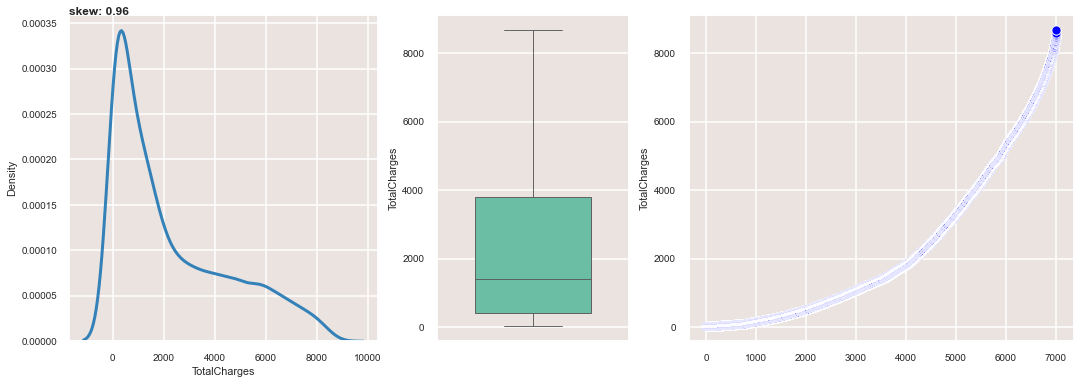

In [160]:
import math
from tqdm import tqdm
def plot_numUFA(df: pd.DataFrame, num_columns: list=None):
    
    assert num_columns!=None, 'Не передан список числовых признаков'

    skewness_list = df[num_columns].skew()
    
    subplot_cnt = len(num_columns)*3
    
    
    n_col = 3
    if len(num_columns) <= n_col/3:
        n_col = 3
        n_row = 1
    else:
        n_row = math.ceil(subplot_cnt / n_col)
    

    fig, axes = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(n_col * 6, n_row * 6),
        gridspec_kw={"hspace": 0.4, "wspace": 0.2, "width_ratios": [0.8, 0.5, 1]},
    )
    axes = axes.flatten()
    i = 0
    for column in tqdm(num_columns):

         # __Распределение__
        ax = axes[i]
        sns.kdeplot(data=df, 
                    x=column, 
                    ax=ax, 
                    fill=False, 
                    alpha=0.9, 
                    legend=False, 
                    linewidth=3, 
                    palette = 'Set2',
                   )

        skewness = skewness_list[column]
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[-1],
            f"skew: {skewness:.2f}",
            size=12,
            weight="bold",
        )
        i = i+1



        #__Бокс__
        ax = axes[i]
        sns.boxplot(
            data=df,
            #x="Churn",
            y=column,
            ax=ax,
            width=0.6,
            saturation=0.9,
            linewidth=0.9,
            palette='Set2',
        )

        i =i + 1



        # __Монотонность__
        df_local = df.copy()
        df_local = df_local.sort_values(by=column).reset_index(drop=True)
        ax = axes[i]
        sns.scatterplot(
            data=df_local, x=df_local.index, y=column,alpha=1, ax=ax, color='b', palette='Set2'
        )
        i = i+1
        
plot_numUFA(X[numeric_cols], num_columns=['TotalCharges'])

- На распределении хорошо виден скос влево и длинный хвост. Подобные качества распределения отрицательно сказываются на качестве масштабирования и центирования.

Попробуем привести распределение признака ближе к нормальному перейдя на новую шкалу:

Преобразование признака TotalCharges:
method= box-cox
lambda = 0.25537409875188244:
Скос:    0.958 -> -0.145
Эксцесс: -0.238 -> -1.039


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]


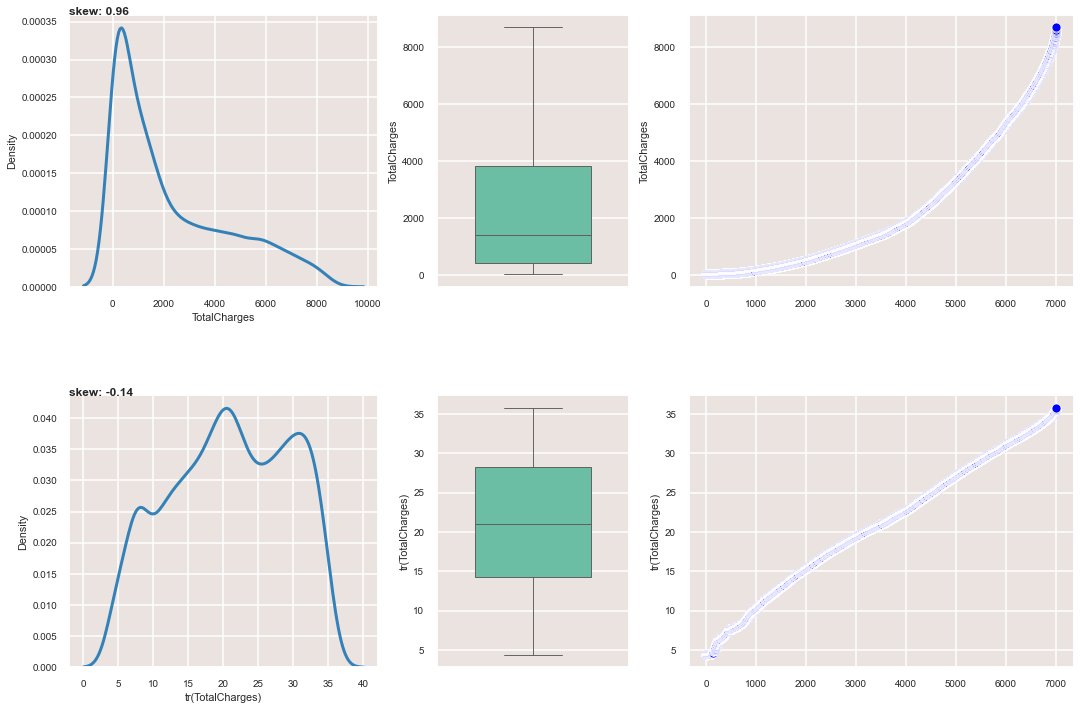

In [161]:
X_norm = plot_bestNorm_transf(X[['TotalCharges']], column_name='TotalCharges')

Качество распределения значительно улучшилось.

#### Исключение линейной зависимости между признаками

При подборе параметров линейной модели ...

Посмотрим еще на корреляции признаков

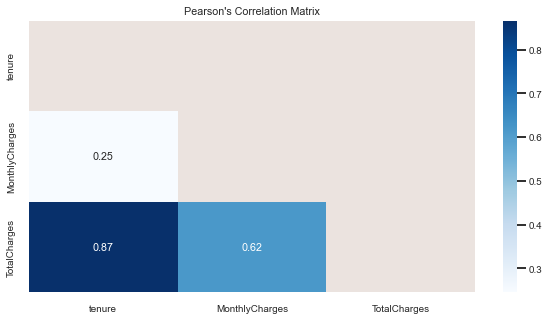

In [110]:
# Проверка ортогональности

corr = X[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(corr, mask=mask, annot=True, cmap="Blues", fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

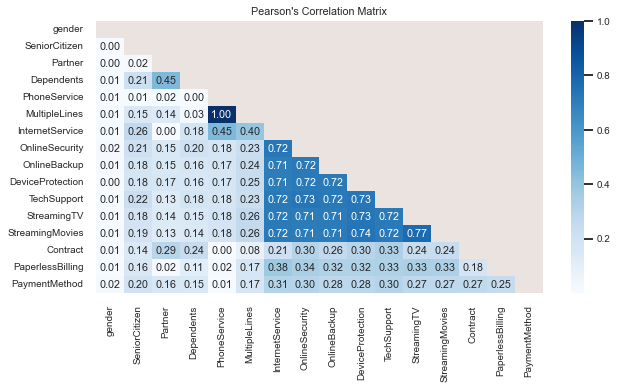

In [111]:
X_temp = X[categoric_cols].astype('category')
cramersv = am.CramersV(X_temp)
cramersv.fit()

mask = np.triu(np.ones_like(cramersv.matrix, dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(cramersv.matrix, mask=mask, annot=True, cmap="Blues", fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

... 
- после применения OHE признаки также являются взаимозависимыми, что потребовало введения большого коэфф. регуляризации при обучении линейной модели.

Для исключения линеной зависисомти между признаками в модель будем передавать ортонормированные признаки. Для жтого, после обработки, применим метод PCA.

In [112]:
from sklearn.decomposition import PCA

def plot_PCA_Explorer (X_scaled, n_components=None):
    pca = PCA(n_components)
    temp = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10,10))
    
    exp_var = pca.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)

    plt.bar(list(range(1, len(pca.get_feature_names_out())+1)), exp_var, align='center', label='Individual explained variance')
    plt.step(list(range(1, len(pca.get_feature_names_out())+1)), cum_exp_var, label='Inqdividual explained variance', linewidth=3, color='red')
    plt.xticks(ticks=list(range(1, len(pca.get_feature_names_out())+1)))
    plt.yticks(ticks=list(range(10, 105, 5)))

def PCA_transformation(X:pd.DataFrame, n_components: int):
    df_local = X.copy()
    
    PCA_local = PCA(n_components=n_components)
    df_local = PCA_local.fit_transform(df_local)
    df_local = pd.DataFrame(df_local, columns=PCA_local.get_feature_names_out())
    df_local.head()
    
    return df_local

Приведем все числовые признаки к одному масштабу и центрируем - для этого используем StandartScaler

<AxesSubplot:title={'center':'После стандартизации'}>

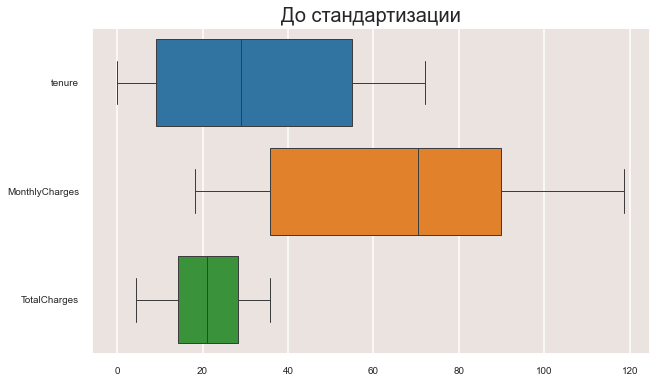

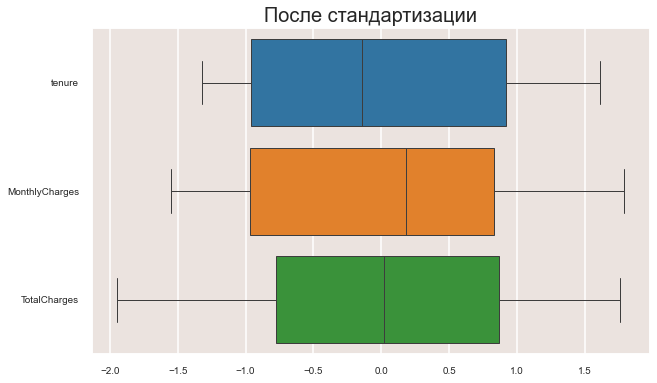

In [113]:
# Подготовка данных (стандартизация)
from sklearn.preprocessing import StandardScaler


plt.figure(figsize=(10,6))
plt.title('До стандартизации', fontsize=20)
sns.boxplot(data=X[numeric_cols], orient='h')

scaler = StandardScaler()
scaler.fit(X[numeric_cols])
X_num_scaled = pd.DataFrame(scaler.transform(X[numeric_cols]), columns = scaler.get_feature_names_out())

plt.figure(figsize=(10,6))
plt.title('После стандартизации', fontsize=20)
sns.boxplot(data=X_num_scaled, orient='h')

Категориальные признаки признаки закодируем методом OneHotEncoder

In [114]:
X_cat_OHE = pd.get_dummies(X[categoric_cols], drop_first=True)

In [115]:
X_cat_OHE.head()

,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Объединим обе части в один DataFrame

In [116]:
X_prepared = pd.concat([X_num_scaled, X_cat_OHE], axis=1).dropna()
X_prepared.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.282728,-1.164135,-1.823625,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0.062387,-0.262811,0.248951,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,-1.241967,-0.365914,-1.395487,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0.510759,-0.750058,0.227845,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,-1.241967,0.194503,-1.257704,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Проведем преобразование PCA и посмотрим на распределение собственных чисел

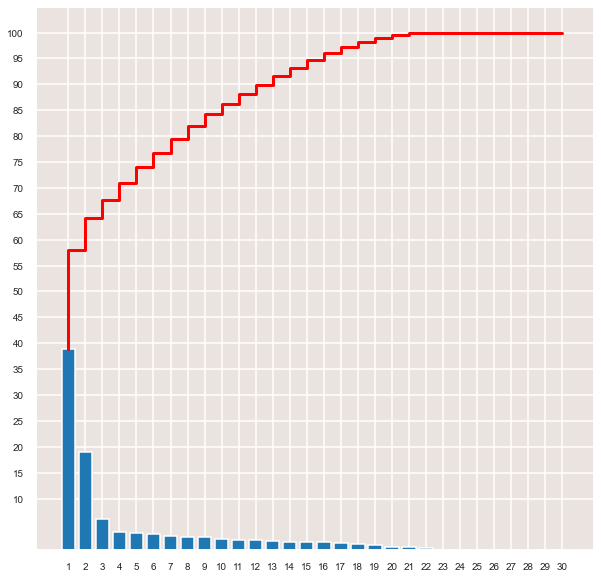

In [117]:
plot_PCA_Explorer(X_prepared.dropna())

Хорошо видно, что:
- первые 18 из 30 признаков ортонормированной системы дают больше 95% информации;
- первые 21 из 30 признаков ортонормированной системы дают 100% информации.

Посмотрим на наличие линейной корреляции между получившимися признаками

In [118]:
X_PCA = PCA_transformation(X_prepared, n_components=21)
X_PCA.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,1.877399,-1.504195,1.225963,-0.076616,1.254406,0.747651,0.154495,-0.173671,0.152971,0.189939,0.456341,0.633732,-0.573320,-0.040399,0.114167,0.072713,-0.011680,-0.581829,0.443785,0.229013,-0.122033
1,0.076976,0.061349,0.983232,-0.371402,-0.663136,-0.682060,-0.325231,0.882912,-0.623362,0.050459,-0.589861,-0.275212,0.200043,0.671645,-0.002466,-0.522109,0.070566,-0.068393,-0.331300,0.045561,-0.222407
2,1.332764,-1.450019,0.903631,-0.074781,-0.490706,-0.505945,-0.553818,-0.076176,0.021797,0.957623,0.481883,0.251116,0.000124,0.102278,0.483815,-0.510630,-0.000391,-0.189768,-0.284175,0.083380,-0.126542
3,-0.019187,0.469145,1.877046,-0.833719,-0.060065,-0.542441,0.130960,0.650812,-0.377365,-0.392953,-0.317227,-0.568080,-0.143179,0.430712,-0.115477,0.085863,0.072550,0.163598,0.748390,0.218369,0.370027
4,0.949982,-2.000447,-0.301829,-0.261280,0.306713,0.556744,-0.241727,-0.160067,-0.027373,-0.004426,0.182341,-0.229705,0.512152,0.194155,-0.258135,-0.001842,-0.042407,-0.116842,0.105652,0.243200,-0.134847


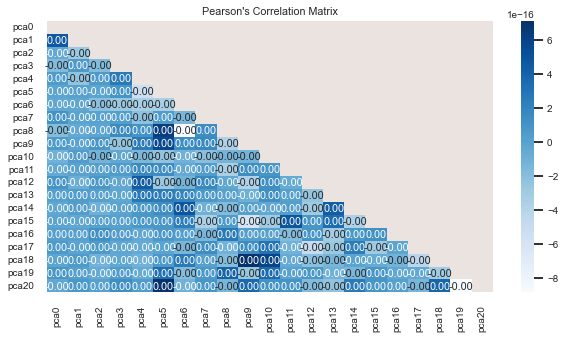

In [119]:
# Проверка ортогональности

corr = X_PCA.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(corr, mask=mask, annot=True, cmap="Blues", fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

Таким образом имеем ортонормированную систему координат.

Используя данные преобразования попробуем улучшить качество линейной модели